# IBM Data Science Capstone Project
-----------------------------------

## *Introduction Section & Problem Statement*

Analysis of the Bar Locations &  Estates in Singapore for Re-Opening in Next Phase of Covid-19 

Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using, even if it is only Foursquare location data. All these questions and more will be answered below. The whole process will be carried out via the below plan:

1) Identify the Names of the Bars in Singapore and its Locations through Web-Scrapping.

2) Use Foresquare Data to Obtain info about Most Popular Venues.

3) Use Clustering to identify Close-Proximity of Bar Locations.

4) Visualization using Folium and HeatMap

In [1]:
!pip install folium  
!pip install geopy         
!pip install tqdm
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from folium.plugins import HeatMap
# Numpy and Pandas libraries were already imported at the beginning of this notebook.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from math import sqrt, pi
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from tqdm import tqdm
import requests # library to handle requests
import lxml.html as lh
import bs4 as bs
import urllib.request

print('Libraries imported.')

Libraries imported.


## Web-Scrapping on Wikipedia

In [2]:
# Importing data from Wikipedia
df_sg = pd.read_html("http://en.wikipedia.org/wiki/Planning_Areas_of_Singapore", flavor='html5lib', header=0)[2]
df_sg.head()

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


In [3]:
# Dropping not-needed columns, renaming columns, and replacing empty values
df_sg.drop(columns=["Malay", "Chinese", "Pinyin", "Tamil"], inplace = True)
df_sg.columns = ["Estate", "Region", "Area", "Population", "Density"]
df_sg.replace("*", 0, inplace=True)
df_sg.head()

,Estate,Region,Area,Population,Density
0,Ang Mo Kio,North-East,13.94,163950,13400
1,Bedok,East,21.69,279380,13000
2,Bishan,Central,7.62,88010,12000
3,Boon Lay,West,8.23,30,3.6
4,Bukit Batok,West,11.13,153740,14000


In [4]:
df_sg = df_sg.astype({"Population":"float64", "Density":"float64"})
df_sg.dtypes

Estate         object
Region         object
Area          float64
Population    float64
Density       float64
dtype: object

## Data Acquisition - Geolocater Nominatim

In [5]:
# Obtain Coordinates of Singapore 
geolocator = Nominatim(user_agent="Mozilla/76.0")
location = geolocator.geocode("Singapore")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of Singapore are {latitude}, {longitude}")

Coordinates of Singapore are 1.357107, 103.8194992


In [6]:
# Coordinates of each Estate, and adding suffix to search query
tqdm.pandas()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
coords = (df_sg["Estate"] + " suburb, Singapore").progress_apply(geocode)

timeout=1)'))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\anush\AppData\Local\Programs\Python\Python38-32\lib\site-packages\geopy\extra\rate_limiter.py", line 136, in _retries_gen
    yield i  # Run the function.
  File "C:\Users\anush\AppData\Local\Programs\Python\Python38-32\lib\site-packages\geopy\extra\rate_limiter.py", line 274, in __call__
    res = self.func(*args, **kwargs)
  File "C:\Users\anush\AppData\Local\Programs\Python\Python38-32\lib\site-packages\geopy\geocoders\nominatim.py", line 297, in geocode
    return self._call_geocoder(url, callback, timeout=timeout)
  File "C:\Users\anush\AppData\Local\Programs\Python\Python38-32\lib\site-packages\geopy\geocoders\base.py", line 360, in _call_geocoder
    result = self.adapter.get_json(url, timeout=timeout, headers=req_headers)
  File "C:\Users\anush\AppData\Local\Programs\Python\Python38-32\lib\site-packages\geopy\adapters.py", line 377, in get_json

In [7]:
# Adding of Latitude and Longitude columns to dataframe
df_sg["Latitude"] = np.nan
df_sg["Longitude"] = np.nan
df_sg.head()

,Estate,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,163950.0,13400.0,NaN,NaN
1,Bedok,East,21.69,279380.0,13000.0,NaN,NaN
2,Bishan,Central,7.62,88010.0,12000.0,NaN,NaN
3,Boon Lay,West,8.23,30.0,3.6,NaN,NaN
4,Bukit Batok,West,11.13,153740.0,14000.0,NaN,NaN


In [8]:
# Insert Coordinates to the Latitude and Longitude columns
for index in df_sg.index:
    df_sg.at[index, 'Latitude'] = coords[index].latitude
    df_sg.at[index, 'Longitude'] = coords[index].longitude
    
df_sg.head()

,Estate,Region,Area,Population,Density,Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,163950.0,13400.0,1.369842,103.846609
1,Bedok,East,21.69,279380.0,13000.0,1.325670,103.931471
2,Bishan,Central,7.62,88010.0,12000.0,1.351912,103.848971
3,Boon Lay,West,8.23,30.0,3.6,1.313620,103.698827
4,Bukit Batok,West,11.13,153740.0,14000.0,1.348283,103.749019


In [9]:
# Adding a new Search Radius column for FourSquare into dataframe, and re-ordering columns
df_sg["Search Radius"] = df_sg["Area"].apply(lambda x: round(sqrt(x/pi)*1000))
df_sg = df_sg[['Estate', 'Region', 'Area', 'Search Radius', 'Population', 'Density', 'Latitude', 'Longitude']]

In [10]:
# Visualisation
# Add map markers for each Estate
sg_map = folium.Map(location = [latitude, longitude], zoom_start = 12)
for lat, lng, region, name in zip(df_sg['Latitude'], df_sg['Longitude'], df_sg['Region'], df_sg['Estate']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sg_map)

sg_map

## Data Acquisition - Four Square

In [11]:
# Four Square API credentials
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
ACCESS_TOKEN =  # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: J3AU325ZRYMH3LJT35535KFAH4CQU4JHQQPSD3RCVIUKIXPS
CLIENT_SECRET:NFZH0EQHUM3Z41NNEIXHCHVVILOTP4XWSQA1NNPG3WVXNZY5


In [12]:
# Function Defined to get nearby venues using the Foursquare API to extract relevant information from the JSON response

def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Estate', 
                  'Est Latitude', 
                  'Est Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
# Calling of the user-defined function for SG Dataframe
sg_venues = getNearbyVenues(names=df_sg['Estate'],
                                   latitudes=df_sg['Latitude'],
                                   longitudes=df_sg['Longitude'],
                                   radius=df_sg['Search Radius']
                                  )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [14]:
sg_venues.head(10)

,Estate,Est Latitude,Est Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.369842,103.846609,Bishan - Ang Mo Kio Park,1.362219,103.846250,Park
1,Ang Mo Kio,1.369842,103.846609,Aramsa ~ The Garden Spa,1.362292,103.847602,Spa
2,Ang Mo Kio,1.369842,103.846609,Old Chang Kee,1.369094,103.848389,Snack Place
3,Ang Mo Kio,1.369842,103.846609,FairPrice Xtra,1.369279,103.848886,Supermarket
4,Ang Mo Kio,1.369842,103.846609,MOS Burger,1.369170,103.847831,Burger Joint
5,Ang Mo Kio,1.369842,103.846609,NTUC FairPrice,1.371507,103.847082,Supermarket
6,Ang Mo Kio,1.369842,103.846609,Face Ban Mian 非板面 (Ang Mo Kio),1.372031,103.847504,Noodle House
7,Ang Mo Kio,1.369842,103.846609,A&W,1.369541,103.849043,Fast Food Restaurant
8,Ang Mo Kio,1.369842,103.846609,Pepper Lunch,1.369107,103.847791,Japanese Restaurant
9,Ang Mo Kio,1.369842,103.846609,Bangkok Street Mookata,1.365688,103.853186,BBQ Joint


## One Hot Encoding 

In [15]:
# Using of One Hot Encoding Method
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot.insert(loc = 0, column = 'Estate', value = sg_venues['Estate'])

# summing one-hot values
sg_onehot = sg_onehot.groupby('Estate').sum().reset_index()
sg_onehot.head()

,Estate,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Cantonese Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Stadium,College Theater,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighthouse,Lingerie Store,Lounge,Malay Restaurant,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Cl

## Data Exploration

In [16]:
# Select Bars in Estate
sg_barh = sg_onehot[['Estate','Bar']]
sg_barh = sg_barh.sort_values(by='Bar', ascending=False)
sg_barh.reset_index(drop=True, inplace=True)
sg_barh10 = sg_barh.head(10)
sg_barh10

,Estate,Bar
0,Marine Parade,3
1,Singapore River,2
2,Queenstown,2
3,Kallang,2
4,Bukit Timah,2
5,Ang Mo Kio,2
6,Bishan,2
7,Sungei Kadut,1
8,Tanglin,1
9,Tuas,1


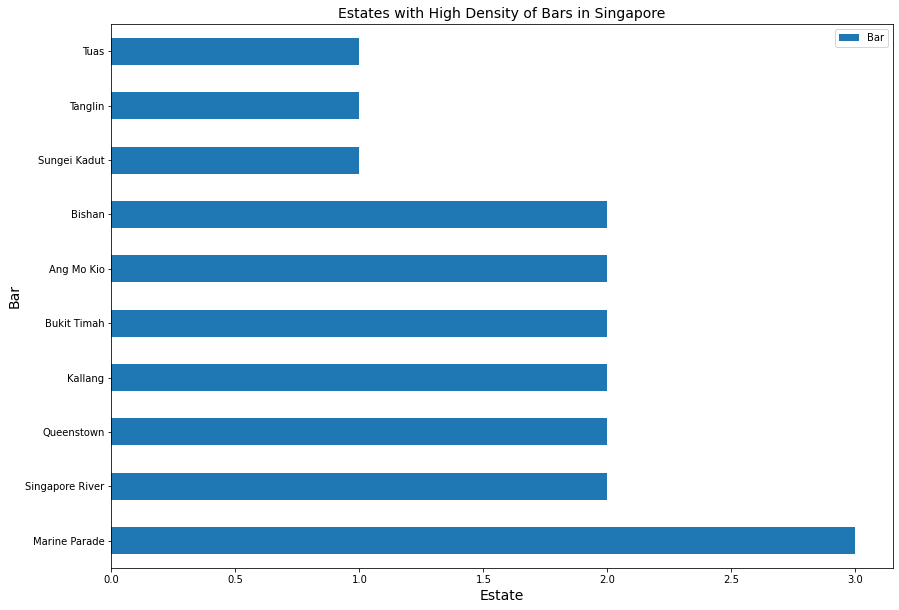

In [17]:
# Plotting bar chart
sg_barh10.plot(kind='barh', x='Estate', y='Bar', figsize=(14,10))
plt.xlabel('Estate', fontsize=14)
plt.ylabel('Bar', fontsize=14)
plt.title(f'Estates with High Density of Bars in Singapore', fontsize=14)

plt.show()

## Visualisation of Bars in Singapore

In [18]:
sg_bar = sg_venues[sg_venues['Venue Category'].str.match('Bar')].reset_index(drop=True)
sg_bar = sg_bar.drop(columns=['Est Latitude', 'Est Longitude'])
sg_bar.head()

,Estate,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,Middle Rock Garden Bar,1.362181,103.847203,Bar
1,Ang Mo Kio,Canopy Garden Dining & Bar,1.362303,103.847399,Bar
2,Bishan,Middle Rock Garden Bar,1.362181,103.847203,Bar
3,Bishan,Canopy Garden Dining & Bar,1.362303,103.847399,Bar
4,Bukit Merah,Junior,1.278958,103.844180,Bar


In [19]:
sg_bar.shape

(29, 5)

In [20]:
barmap_sg = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, bar in zip(sg_bar['Venue Latitude'], sg_bar['Venue Longitude'], sg_bar['Venue']):
    label = '{}'.format(bar)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(barmap_sg)  
    
barmap_sg

## K-Mean Clustering

In [21]:
good_latitudes = sg_bar['Venue Latitude'].values
good_longitudes = sg_bar['Venue Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_bar = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_bar) 

map_bar

In [22]:
map_bar = folium.Map(location=[latitude, longitude], zoom_start=12.4)
HeatMap(good_locations, radius=25).add_to(map_bar)

for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_bar)

map_bar

In [23]:
distortions = []
types = sg_bar[['Venue Latitude','Venue Longitude']]
K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(types)
    distortions.append(kmean.inertia_)

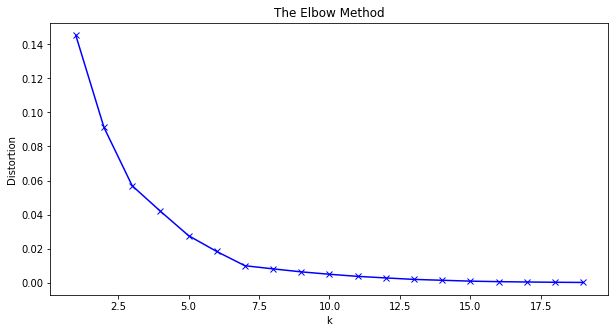

In [24]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [25]:
# Run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(types)

sg_bar['Cluster'] = kmeans.labels_
sg_bar.head()

,Estate,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
0,Ang Mo Kio,Middle Rock Garden Bar,1.362181,103.847203,Bar,3
1,Ang Mo Kio,Canopy Garden Dining & Bar,1.362303,103.847399,Bar,3
2,Bishan,Middle Rock Garden Bar,1.362181,103.847203,Bar,3
3,Bishan,Canopy Garden Dining & Bar,1.362303,103.847399,Bar,3
4,Bukit Merah,Junior,1.278958,103.844180,Bar,0


In [26]:
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster in zip(sg_bar['Venue Latitude'], sg_bar['Venue Longitude'], sg_bar['Cluster']):
    
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_bar)
       
map_bar 